<a href="https://colab.research.google.com/github/SimpleVlad/NeuralNetsExperiments/blob/main/Vanila_GAN_with_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())


import sys, subprocess

IN_COLAB = "google.colab" in sys.modules
colab_requirements = ["pip install tf-nightly-gpu-2.0-preview==2.0.0.dev20190513"]
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


In [3]:
print(tf.__version__)

2.3.0


In [4]:
TRAIN_BUF=60000
BATCH_SIZE=512
TEST_BUF=10000
DIMS = (28,28,1)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [5]:
# load dataset
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

# split dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(
    "float32"
) / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

11493376/11490434 [==============================] - 0s 0us/step


In [6]:
class GAN(tf.keras.Model):
    """ a basic GAN class 
    Extends:
        tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(GAN, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):
        """ passes through the network and computes loss
        """
        # generating noise from a uniform distribution
        z_samp = tf.random.normal([x.shape[0], 1, 1, self.n_Z])

        # run noise through generator
        x_gen = self.generate(z_samp)
        # discriminate x and x_gen
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)
        ### losses
        # losses of real with label "1"
        disc_real_loss = gan_loss(logits=logits_x, is_real=True)
        # losses of fake with label "0"
        disc_fake_loss = gan_loss(logits=logits_x_gen, is_real=False)
        disc_loss = disc_fake_loss + disc_real_loss

        # losses of fake with label "1"
        gen_loss = gan_loss(logits=logits_x_gen, is_real=True)

        return disc_loss, gen_loss

    def compute_gradients(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):

        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )
    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)
        
        
def gan_loss(logits, is_real=True):
    """Computes standard gan loss between logits and labels
    """
    if is_real:
        labels = tf.ones_like(logits)
    else:
        labels = tf.zeros_like(logits)

    return tf.compat.v1.losses.sigmoid_cross_entropy(
        multi_class_labels=labels, logits=logits
    )

In [7]:
N_Z = 64
generator = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

discriminator = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation=None),
]

In [8]:
# optimizers
gen_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(0.005)# train the model
# model
model = GAN(
    gen = generator,
    disc = discriminator,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    n_Z = N_Z
)

In [9]:
# exampled data for plotting results
def plot_reconstruction(model, nex=8, zm=2):
    samples = model.generate(tf.random.normal(shape=(BATCH_SIZE, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()

In [10]:
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])


Epoch: 0 | disc_loss: 0.8078539967536926 | gen_loss: 1.8100162744522095


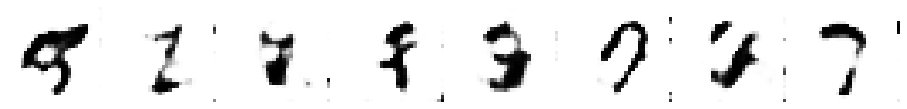


Epoch: 1 | disc_loss: 0.8233515620231628 | gen_loss: 1.3466249704360962


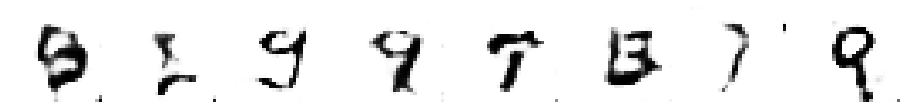


Epoch: 2 | disc_loss: 1.1411716938018799 | gen_loss: 1.9628818035125732


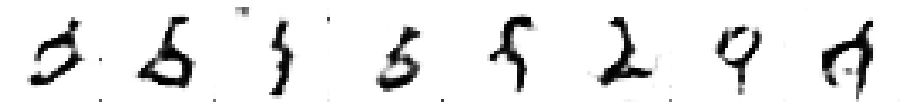


Epoch: 3 | disc_loss: 0.8782989382743835 | gen_loss: 0.9756713509559631


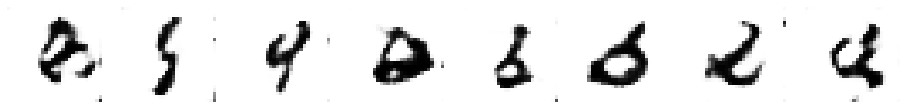


Epoch: 4 | disc_loss: 0.8417760729789734 | gen_loss: 1.986872673034668


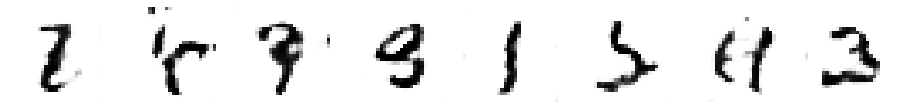


Epoch: 5 | disc_loss: 0.6997926831245422 | gen_loss: 1.5131946802139282


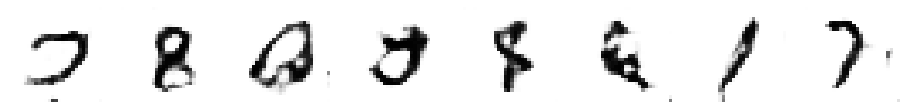


Epoch: 6 | disc_loss: 0.8113623857498169 | gen_loss: 2.269876480102539


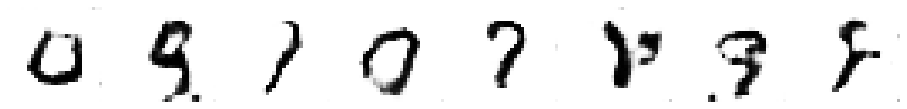


Epoch: 7 | disc_loss: 0.7471312284469604 | gen_loss: 1.4933451414108276


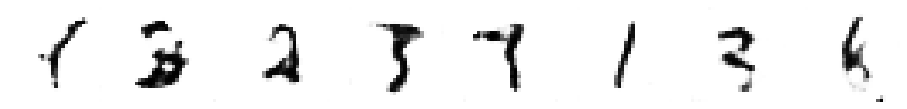


Epoch: 8 | disc_loss: 0.8567306399345398 | gen_loss: 2.1624763011932373


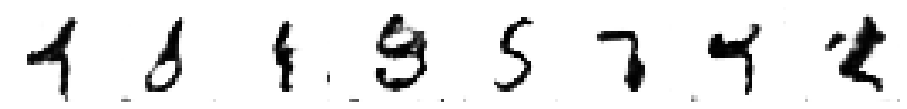


Epoch: 9 | disc_loss: 0.7768247127532959 | gen_loss: 1.3325365781784058


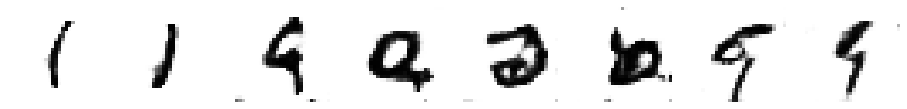


Epoch: 10 | disc_loss: 0.8695639371871948 | gen_loss: 2.3563435077667236


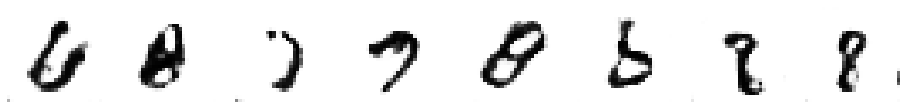


Epoch: 11 | disc_loss: 0.9010367393493652 | gen_loss: 1.0091753005981445


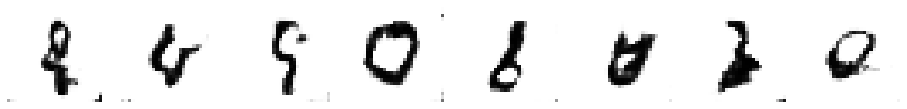


Epoch: 12 | disc_loss: 1.0269137620925903 | gen_loss: 2.7460031509399414


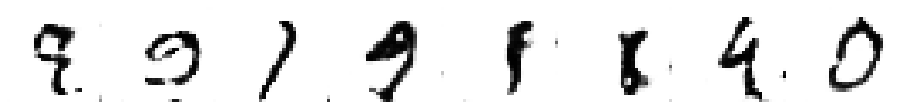


Epoch: 13 | disc_loss: 0.8651863932609558 | gen_loss: 1.0730347633361816


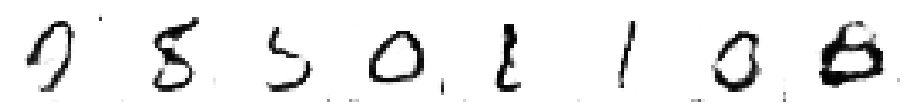


Epoch: 14 | disc_loss: 0.9414505362510681 | gen_loss: 2.165952444076538


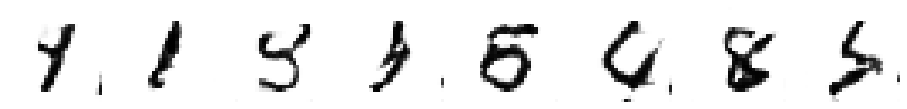


Epoch: 15 | disc_loss: 0.9281729459762573 | gen_loss: 0.9364261627197266


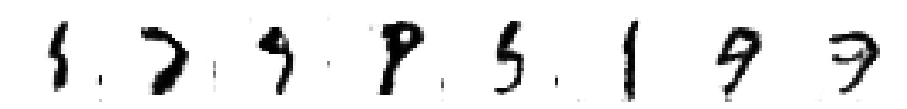


Epoch: 16 | disc_loss: 1.0448466539382935 | gen_loss: 0.8007190823554993


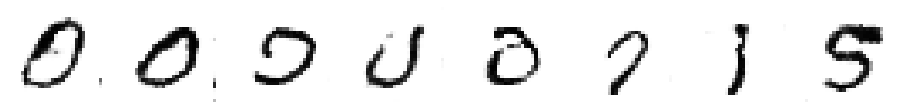


Epoch: 17 | disc_loss: 0.8804616332054138 | gen_loss: 2.172271251678467


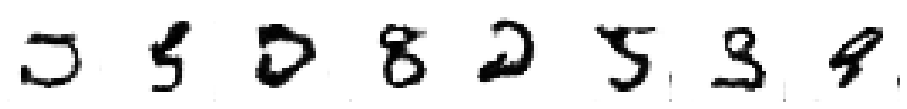


Epoch: 18 | disc_loss: 0.9597471952438354 | gen_loss: 0.89666348695755


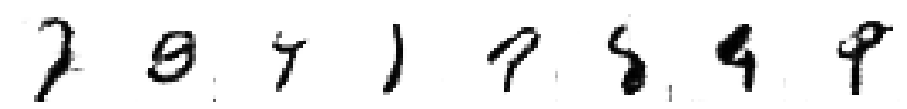


Epoch: 19 | disc_loss: 0.7793454527854919 | gen_loss: 1.9833122491836548


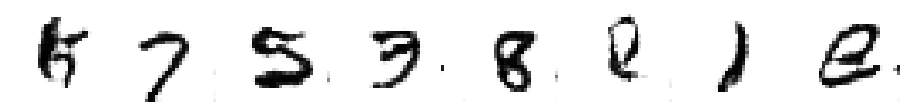


Epoch: 20 | disc_loss: 0.8381943106651306 | gen_loss: 1.1833724975585938


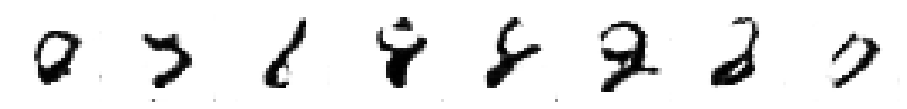


Epoch: 21 | disc_loss: 0.853654146194458 | gen_loss: 2.4783332347869873


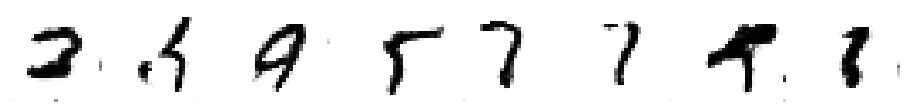


Epoch: 22 | disc_loss: 0.914264976978302 | gen_loss: 1.0410610437393188


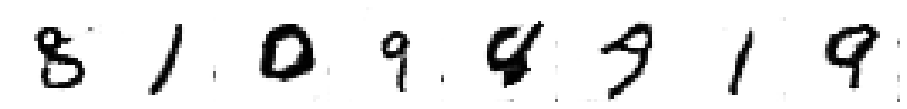


Epoch: 23 | disc_loss: 0.8482222557067871 | gen_loss: 2.0721096992492676


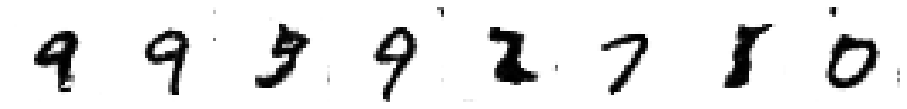


Epoch: 24 | disc_loss: 0.9414812326431274 | gen_loss: 1.0627461671829224


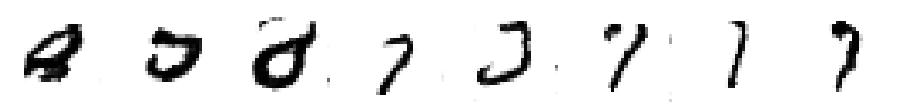


Epoch: 25 | disc_loss: 0.9239826202392578 | gen_loss: 2.008702516555786


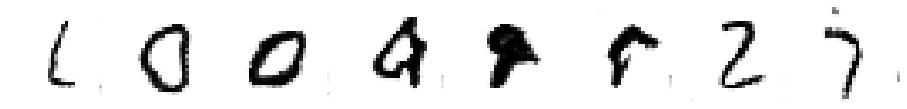


Epoch: 26 | disc_loss: 0.8723536133766174 | gen_loss: 1.2558895349502563


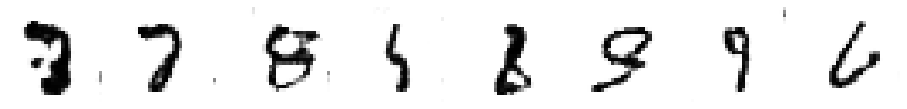


Epoch: 27 | disc_loss: 0.8453545570373535 | gen_loss: 1.626819372177124


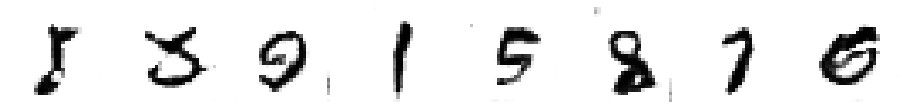


Epoch: 28 | disc_loss: 0.9184187054634094 | gen_loss: 1.076377511024475


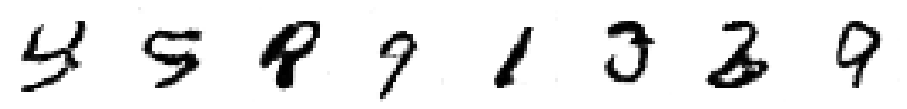


Epoch: 29 | disc_loss: 0.9792220592498779 | gen_loss: 2.0273261070251465


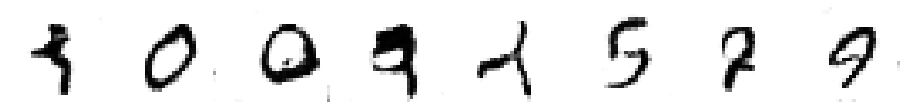


Epoch: 30 | disc_loss: 0.8967079520225525 | gen_loss: 1.936869740486145


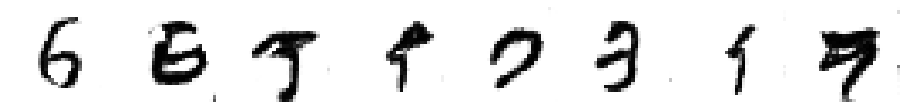


Epoch: 31 | disc_loss: 0.9795422554016113 | gen_loss: 0.9574323892593384


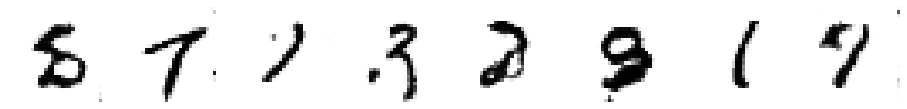


Epoch: 32 | disc_loss: 0.8240748643875122 | gen_loss: 1.5600849390029907


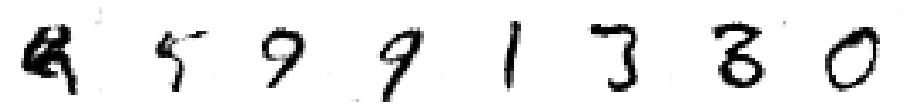


Epoch: 33 | disc_loss: 0.9001699686050415 | gen_loss: 1.177220344543457


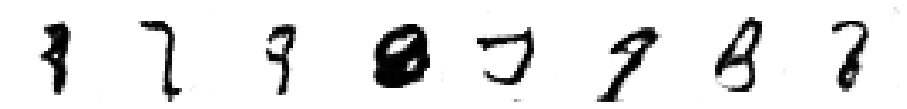


Epoch: 34 | disc_loss: 0.9860939979553223 | gen_loss: 2.284214735031128


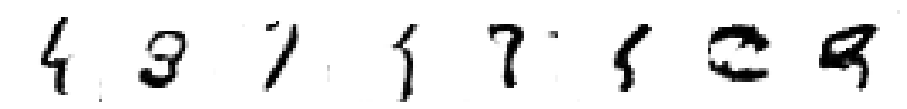


Epoch: 35 | disc_loss: 0.913388729095459 | gen_loss: 1.317326545715332


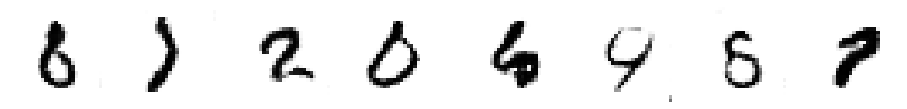


Epoch: 36 | disc_loss: 0.9144482016563416 | gen_loss: 1.6915218830108643


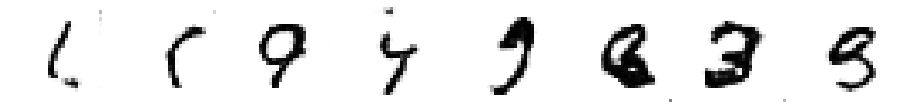


Epoch: 37 | disc_loss: 0.975461483001709 | gen_loss: 1.0266220569610596


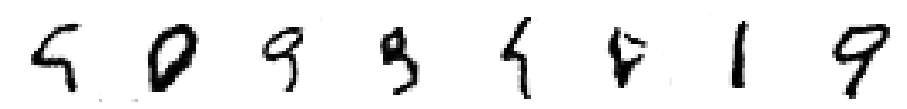


Epoch: 38 | disc_loss: 0.9671552777290344 | gen_loss: 1.8883376121520996


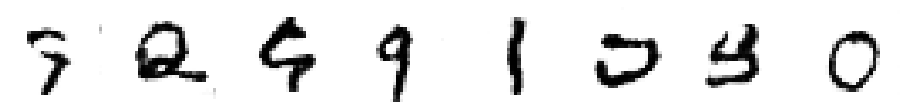


Epoch: 39 | disc_loss: 0.9156297445297241 | gen_loss: 1.22124183177948


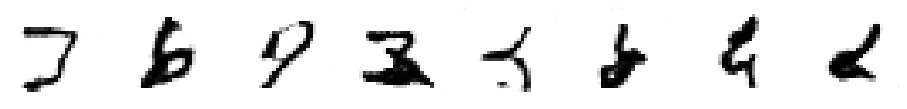


Epoch: 40 | disc_loss: 0.9265674948692322 | gen_loss: 1.5775028467178345


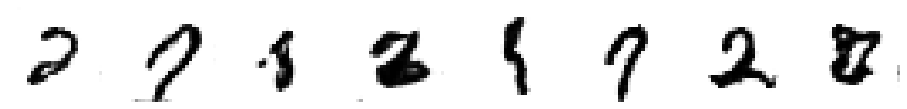


Epoch: 41 | disc_loss: 0.9575004577636719 | gen_loss: 1.8843516111373901


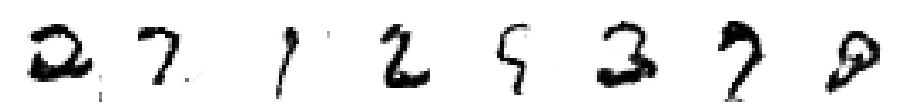


Epoch: 42 | disc_loss: 0.9450196623802185 | gen_loss: 1.122839331626892


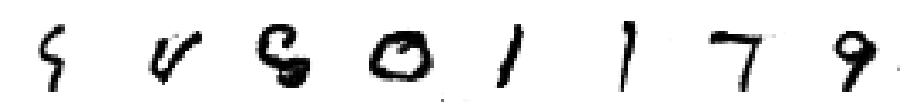


Epoch: 43 | disc_loss: 0.9756332039833069 | gen_loss: 0.9806098937988281


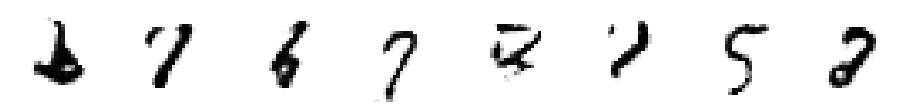


Epoch: 44 | disc_loss: 1.0215344429016113 | gen_loss: 1.7422499656677246


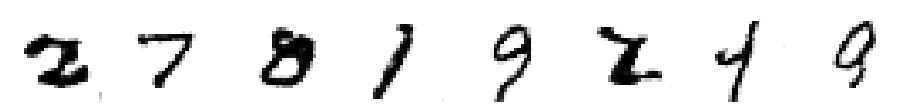


Epoch: 45 | disc_loss: 0.9754601716995239 | gen_loss: 0.9864372611045837


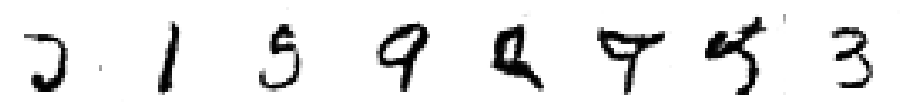


Epoch: 46 | disc_loss: 0.9130890369415283 | gen_loss: 1.5980836153030396


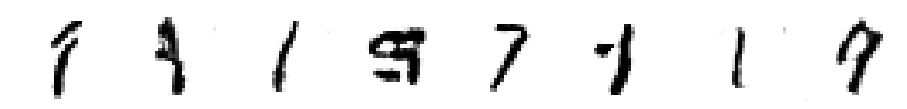


Epoch: 47 | disc_loss: 0.9144647717475891 | gen_loss: 1.746138334274292


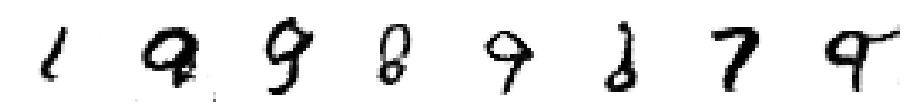


Epoch: 48 | disc_loss: 0.8874068856239319 | gen_loss: 1.240932822227478


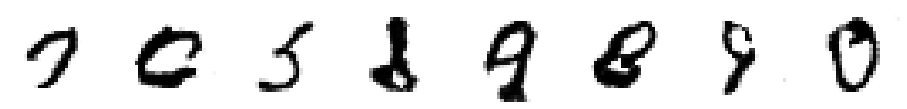


Epoch: 49 | disc_loss: 0.9341448545455933 | gen_loss: 1.5921119451522827


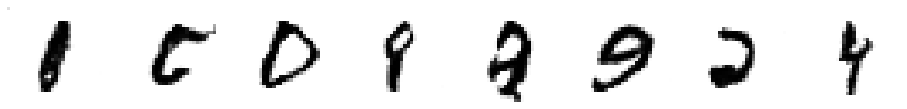

In [13]:

n_epochs = 50
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    # display.clear_output()
    print(
        "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )
    plot_reconstruction(model)
